In [1]:
%matplotlib inline
%time from hikyuu.interactive import *
iodog.open()

std::cout are redirected to python::stdout
std::cerr are redirected to python::stderr
2024-02-29 15:52:37.298 [HKU-I] - Using MYSQL BaseInfoDriver (BaseInfoDriver.cpp:58)
2024-02-29 15:52:37.316 [HKU-I] - Loading market information... (StockManager.cpp:506)
2024-02-29 15:52:37.322 [HKU-I] - Loading stock type information... (StockManager.cpp:519)
2024-02-29 15:52:37.326 [HKU-I] - Loading stock information... (StockManager.cpp:435)
2024-02-29 15:52:37.460 [HKU-I] - Loading stock weight... (StockManager.cpp:536)
2024-02-29 15:52:38.615 [HKU-I] - Loading KData... (StockManager.cpp:132)
2024-02-29 15:52:39.371 [HKU-I] - Preloading all day kdata to buffer! (StockManager.cpp:170)
2024-02-29 15:52:39.372 [HKU-I] - Preloading all week kdata to buffer! (StockManager.cpp:173)
2024-02-29 15:52:39.372 [HKU-I] - Preloading all month kdata to buffer! (StockManager.cpp:176)
2024-02-29 15:52:39.377 [HKU-I] - 0.76s Loaded Data. (StockManager.cpp:149)
CPU times: total: 500 ms
Wall time: 3.16 s


# 一、策略分析

## 原始描述

买入条件：周线MACD零轴下方底部金叉买入30%

卖出条件：日线级别 跌破 20日线 卖出50%持仓


## 策略分析

市场环境：无

系统有效性：无

信号指示器：
- 买入信号：周线MACD零轴下方底部金叉，即周线的DIF>DEA金叉时买入（快线：DIF，慢线DEA）
- 卖出信号：日线级别 跌破 20日均线

止损/止盈：无

资金管理：
- 买入：30% （不明确，暂且当做当前现金的30%）
- 卖出：已持仓股票数的50%

盈利目标：

移滑价差：


# 二、实现系统部件

## 定义信号指示器

In [2]:
def getNextWeekDate(week):
    """获取指定日期的下一周周一日期"""
    from datetime import timedelta
    py_week = week.datetime()
    next_week_start = py_week + timedelta(days = 7 - py_week.weekday())
    return Datetime(next_week_start)

In [3]:
def DEMO_SG(self):
    """
    买入信号：周线MACD零轴下方底部金叉，即周线的DIF>DEA金叉时买入
    卖出信号：日线级别 跌破 20日均线
    
    参数：
    week_macd_n1：周线dif窗口
    week_macd_n2: 周线dea窗口
    week_macd_n3: 周线macd平滑窗口
    day_n: 日均线窗口
    """
    k = self.to
    if (len(k) == 0):
        return
    
    stk = k.get_stock()
    
    #-----------------------------
    #计算日线级别的卖出信号        
    #-----------------------------
    day_c = CLOSE(k)
    day_ma = MA(day_c, self.get_param("day_n"))
    day_x = day_c < day_ma  #收盘价小于均线
    for i in range(day_x.discard, len(day_x)):
        if day_x[i] >= 1.0:
            self._add_sell_signal(k[i].datetime)

    #-----------------------------
    #计算周线级别的买入信号        
    #-----------------------------
    week_q = Query(k[0].datetime, k[-1].datetime.next_day(), ktype=Query.WEEK)
    week_k = k.get_stock().get_kdata(week_q)
    
    n1 = self.get_param("week_macd_n1")
    n2 = self.get_param("week_macd_n2")
    n3 = self.get_param("week_macd_n3")
    m = MACD(CLOSE(week_k), n1, n2, n3)
    fast = m.get_result(0)
    slow = m.get_result(1)
    
    discard = m.discard if m.discard > 1 else 1
    for i in range(discard, len(m)):
        if (fast[i-1] < slow[i-1] and fast[i] > slow[i]):
            #当周计算的结果，只能作为下周一的信号
            self._add_buy_signal(week_k[i].datetime.next_week())
         

## 定义资金管理策略

In [4]:
class DEMO_MM(MoneyManagerBase):
    """
    买入：30% （不明确，暂且当做当前现金的30%）
    卖出：已持仓股票数的50%
    """
    def __init__(self):
        super(DEMO_MM, self).__init__("MACD_MM")
        
    def _reset(self):
        pass
    
    def _clone(self):
        return DEMO_MM()
        
    def _get_buy_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        cash = tm.current_cash
        
        #可以不用考虑最小交易单位的问题，已经自动处理
        #num = int((cash * 0.3 // price // stk.atom) * stk.atom)
        return int(cash*0.3/price) #返回类型必须是int
    
    def _get_sell_num(self, datetime, stk, price, risk, part_from):
        tm = self.tm
        position = tm.get_position(datetime, stk)
        total_num = position.number
        num = int(total_num * 0.5)
        return num if num >= 100 else 0

# 三、构建并运行系统

## 设定系统参数


In [5]:
#账户参数
init_cash = 100000 #账户初始资金
init_date = Datetime('1990-1-1') #账户建立日期

#信号指示器参数
week_n1 = 12
week_n2 = 26
week_n3 = 9
day_n = 20

#选定标的，及测试区间
stk = sm['sz000001']
start_date = Datetime('2017-01-01')  #如果是同一级别K线，可以使用索引号，使用了不同级别的K线数据，建议还是使用日期作为参数
end_date = Datetime()

## 构建系统实例

In [6]:
#创建账户
my_tm = crtTM(date=init_date, init_cash = init_cash, cost_func=TC_FixedA())

#创建系统实例
my_sys = SYS_Simple()

#绑定账户
my_sys.tm = my_tm

#绑定信号指示器
# !注意
# 受限与 pybind11 的限制，这里不能直接使用 my_sys.sg = crtSG(  或 my_sys.mm = DEMO_MM() , 需要先生成 Python 对象的实例再赋值
my_sg = crtSG(DEMO_SG, 
              {'week_macd_n1': week_n1, 'week_macd_n2': week_n2, 'week_macd_n3': week_n3, 'day_n': day_n}, 
                'DEMO_SG') 
my_sys.sg = my_sg
my_sys.sg.set_param('alternate', False)

#绑定资金管理策略
my_mm = DEMO_MM()
my_sys.mm = my_mm

## 运行系统

In [7]:
iodog.close()
q = Query(start_date, end_date, ktype=Query.DAY)
my_sys.run(stk, q)

#将交易记录及持仓情况，保存在临时目录，可用Excel查看
#临时目录一般设置在数据所在目录下的 tmp 子目录
#如果打开了excel记录，再次运行系统前，记得先关闭excel文件，否则新的结果没法保存
my_tm.tocsv(sm.tmpdir())

# 四、查看资金曲线及绩效统计

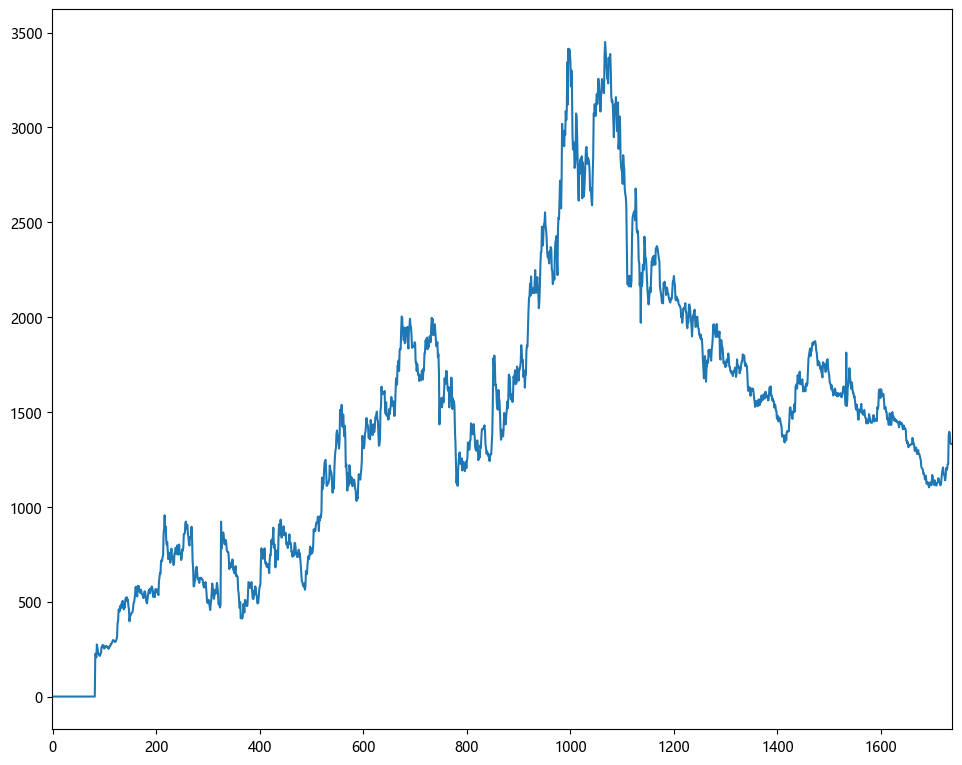

In [8]:
#绘制资金收益曲线（净收益）
x = my_tm.get_profit_curve(stk.get_datetime_list(q), Query.DAY)
#x = my_tm.getFundsCurve(stk.getDatetimeList(q), KQuery.DAY) #总资产曲线
x = PRICELIST(x)
x.plot()

In [9]:
#回测统计
per = Performance()
print(per.report(my_tm, Datetime.now()))

R乘数期望值: 0.00
亏损交易亏损总额: 0.00
亏损交易平均R乘数: 0.00
亏损交易平均亏损: 0.00
亏损交易平均持仓时间: 0.00
亏损交易数: 0.00
亏损交易最大持仓时间: 0.00
交易平均占用现金比例%: 29.34
交易机会频率/年: 0.00
净赢利/亏损比例: 0.00
单笔交易最大占用现金比例%: 30.01
已平仓交易总成本: 0.00
已平仓交易总数: 0.00
已平仓净利润总额: 0.00
已平仓帐户收益率%: 0.00
帐户初始金额: 100000.00
帐户平均年收益率%: 0.20
帐户年复合收益率%: 0.19
平均空仓时间: 2488.00
平均赢利/平均亏损比例: 0.00
年度期望R乘数: 0.00
当前总资产: 101331.66
最大单笔亏损: 0.00
最大单笔亏损R乘数: 0.00
最大单笔亏损百分比%: 0.00
最大单笔盈利百分比%: 0.00
最大单笔赢利: 0.00
最大单笔赢利R乘数: 0.00
最大连续亏损R乘数: 0.00
最大连续亏损笔数: 0.00
最大连续亏损金额: 0.00
最大连续赢利R乘数: 0.00
最大连续赢利笔数: 0.00
最大连续赢利金额: 0.00
最长空仓时间: 2487.00
未平仓头寸净值: 1646.93
现金余额: 99684.73
空仓总时间: 2488.00
空仓时间/总时间%: 100.00
累计借入现金: 0.00
累计借入资产: 0.00
累计投入本金: 100000.00
累计投入资产: 0.00
累计红利: 206.90
赢利交易平均R乘数: 0.00
赢利交易平均持仓时间: 0.00
赢利交易平均赢利: 0.00
赢利交易数: 0.00
赢利交易最大持仓时间: 0.00
赢利交易比例%: 0.00
赢利交易赢利总额: 0.00
赢利期望值: 0.00



# 五、或许想看下图形

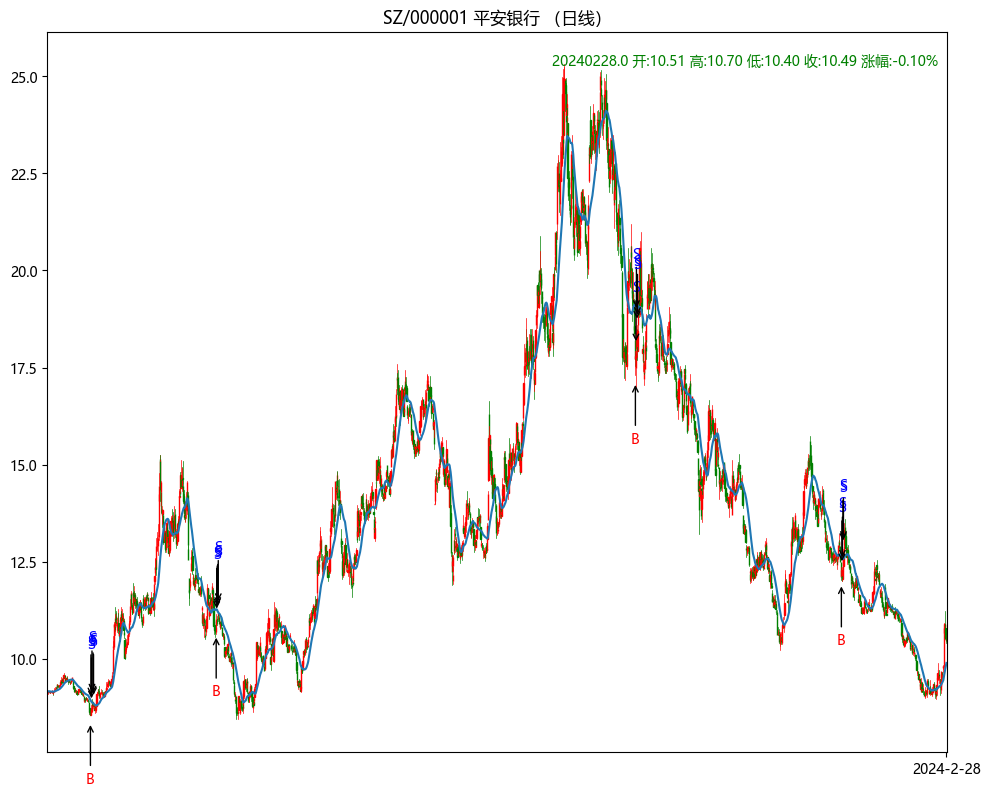

In [10]:
my_sys.plot()
MA(CLOSE(my_sys.to), 20).plot(new=False)

# 六、或许想看看所有股票的情况

In [11]:
import pandas as pd
def calTotal(blk, q):
    per = Performance()
    s_name = []
    s_code = []
    x = []
    for stk in blk:
        my_sys.run(stk, q)
        per.statistics(my_tm, Datetime.now())
        s_name.append(stk.name)
        s_code.append(stk.market_code)
        x.append(per["当前总资产"])
    return pd.DataFrame({'代码': s_code, '股票': s_name, '当前总资产': x})

%time data = calTotal(blocka, q)

CPU times: total: 8.84 s
Wall time: 30.7 s


In [12]:
#保存到CSV文件
#data.to_csv(sm.tmpdir() + '/统计.csv')
data[:10]

,代码,股票,当前总资产
0,SH600605,汇通能源,102872.58
1,SH600606,绿地控股,99094.57
2,SH603272,联翔股份,98478.36
3,SH600354,敦煌种业,106984.32
4,SZ300359,全通教育,98394.08
5,SZ000725,京东方Ａ,97358.10
6,BJ838163,方大新材,99602.61
7,SZ300358,楚天科技,101457.57
8,SH600355,精伦电子,95001.59
9,SH603273,天元智能,100000.00


In [13]:
iodog.close()
my_tm.buy(Datetime(201906160000), sm['sz000001'], 10, 10000)

Trade(+infinity, , , UNKNOWN, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, --)